In [2]:
# import library
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# adjust 한글 font
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# Part 4. 지도학습 기법 2
- Naive Bayes
- Performance Evaluation
- Grid Search

## 4-1 Naive Bayes

### 확률을 이용해 분류문제를 푸는 방법(ML & MLP)
- 관측값을 _z_
- 그 값이 나온 클래스(또는 모델)을 c_라 하면,
$$ML:\;c^,=\underset{c}{\operatorname{argmax}}\,P(z|c)$$
$$MAP:\;c^*=\underset{c}{\operatorname{argmax}}\,P(c|z)=\underset{c}{\operatorname{argmax}}\,P(z|c)P(c)$$
- ML(Maximum likelihood)
- MAP(Maximum A Posteriori)
- 예를 들어,
    - 바닥에 떨어진 머리카락의 길이(z)를 보고 그 머리카락이 **남자(==male)** 것인지 **여자(==female)** 것인지 성별(x)을 판단
    - ML 방법
        - ML 방법은 남자에게서 그러한 머리카락이 나올 확률 $P(z|male)$과
        - 여자에게서 그러한 머리카락이 나올 확률 $P(z|female)$을 비교하여 가장 확률이 큰
        - 즉, **likelihood**가 가장 큰 클래스(성별)을 선택
    - MAP 방법
        - MAP 방법은 z라는 머리카락이 발견되었는데 그것이 남자 것일 확률 $P(male|z)$,
        - 그것이 여자 것일 확률 $P(female|z)$를 비교해서 둘 중 큰 값을 갖는 클래스(성별)을 선택
        - 즉, **사후확률(posterior probability)**를 최대화시키는 방법으로서 MAP에서 사후확률을 계산할 때 베이즈 정리 사용
    - 둘의 차이는?
        - ML과 MAP의 차이는 남녀의 성비를 고려하면 명확
        - 만일 인구의 90%가 남자고 여자는 10% 밖에 없다고 가정
        - ML은 남녀의 성비를 완전히 무시함
            - 남자 중에서 해당 길이의 머리카락을 가질 확률
            - 여자 중에서 해당 길이의 머리카락을 가질 확률만을 비교
        - MAP는 각각의 성에서 해당 머리카락이 나올 확률 뿐만 아니라 남녀의 성비까지 고려하여 최종 클래스를 결정
- 정리하며느 ML보다는 MAP 방법이 보다 정확한 classification 방법
- 하지만 많은 경우, 사전확률(prior probability)인 p(남), p(여)를 모르는 경우가 대부분이기 때문에 단순하게 p(남) = p(여)로 놓고 문제를 푸는 경우가 많음
    - 이 경우 MAP는 ML과 같게 됨

### pure, naive, semi-naive Bayesian
$$Pure\;Baysian:\,P(f_1,f_2,...,f_N|C_k)$$
$$Naive\;Baysian:\,P(f_1,f_2,...,f_N|C_k)=\prod_{i=1}^{N}P(f_i|C_k)$$
$$Semi-Naive\;Baysian:\,P(f_1,f_2,...,f_N|C_k)=\prod_{i=1}^{M}P(F_i|C_k)$$
- naive는 각 특징들이 서로 상관관계가 없는 독립변수라는 가정 하에 각각의 확률분포를 구하고 서로 곱하여 최종 결합확률을 계산
- 반면 pure는 모든 조합에 대한 확률분포를 계산. 물론 상관관계가 고려되어야 한다면 pure가 더 정확함
- 그렇지만 pure의 확률분포를 구하기 어렵기 때문에 naive를 사용
- semi-naive는 특징들을 여러 소그룹으로 만든 뒤, 각 특징들 간의 상관관계를 사용하여 계산하되, 그룹 간에는 naive와 같이 계산
- 상관관계가 있는 특징들끼리만 그룹핑한다면 가장 효율적인 모델이 됨

### Prepare Dataset and fn

In [2]:
def load_dataset():
    posting_list = [
        'my dog has flea problems help please'.split(),
        'maybe not take him to dog park stupid'.split(),
        'my dalmation is so cute i love him'.split(),
        'stop posting stupid worthless garbage'.split(),
        'mr licks ate my steak how to stop him'.split(),
        'quit buying worthless dog food stupid'.split()
    ]
    class_vec = [0, 1, 0, 1, 0, 1]
    return posting_list, class_vec

# def create_vocab_li(dataset):
#     vocabset = set()
#     for doc in dataset:
#         vocabset = vocabset.union(set(doc))
#     return list(vocabset)

def create_vocab_li(dataset):
    return list(set([content for li in dataset for content in li]))

def set_of_word2_vec(vocabset, inputset):
    res = [0] * len(vocabset)
    for word in inputset:
        if word in vocabset:
            res[vocabset.index(word)] = 1
    return res

In [3]:
train, label = load_dataset()
train, label

([['my', 'dog', 'has', 'flea', 'problems', 'help', 'please'],
  ['maybe', 'not', 'take', 'him', 'to', 'dog', 'park', 'stupid'],
  ['my', 'dalmation', 'is', 'so', 'cute', 'i', 'love', 'him'],
  ['stop', 'posting', 'stupid', 'worthless', 'garbage'],
  ['mr', 'licks', 'ate', 'my', 'steak', 'how', 'to', 'stop', 'him'],
  ['quit', 'buying', 'worthless', 'dog', 'food', 'stupid']],
 [0, 1, 0, 1, 0, 1])

In [4]:
voca_li = create_vocab_li(train)
print(voca_li)

['worthless', 'cute', 'ate', 'stop', 'not', 'posting', 'garbage', 'quit', 'love', 'licks', 'take', 'so', 'maybe', 'to', 'dalmation', 'buying', 'flea', 'mr', 'him', 'problems', 'dog', 'is', 'please', 'help', 'park', 'my', 'steak', 'has', 'i', 'food', 'stupid', 'how']


In [5]:
set_of_word2_vec(voca_li, train[0]) # make sparse vector

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0]

### Training : Calculate Probabilities by Word Vec

In [ ]:
Count the number of documents in each class
# 각 분류 항목에 대한 문서의 개수 세기
for every training document:
    # 훈련을 위한 모든 문서의 개수 세기
    for each class:
        # 분류 항목 개수만큼 반복
        if a token appears in the document -> increment the count for that token
        # 해당 토큰이 문서 내에 있으면 -> 해당 토큰에 대한 개수를 증가
        increment the count for tokens
        # 토큰에 대한 개수를 증가`
    for each class:
        # 분류 항목 개수만큼 반복
        for each token:
            # 토큰의 개수만큼 반복
            divide the toke ncount by the total token count to get conditional
probabilities
        # 조건부 확률을 구하기 우해 해당 토큰의 개수를 토큰 전체의 수로 나눔
    return conditional probabilities for each class

In [7]:
a, b = np.zeros((2, 5))
a, b

(array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]))

In [78]:
def train_NB0(train_mat, train_cat, num_init=0, denom_init=0):
    num_train_docs = len(train_mat)
    num_word = len(train_mat[0])
    p_abusive = sum(train_cat) / float(num_train_docs)
    p0_num, p1_num = np.ones([2, num_word]) * num_init
    p0_denom, p1_denom = denom_init, denom_init
    for i in range(num_train_docs):
        if train_cat[i] == 1:
            p1_num += train_mat[i]
            p1_denom += sum(train_mat[i])
        else:
            p0_num += train_mat[i]
            p0_denom += sum(train_mat[i])
    p1_vect = p1_num / p1_denom
    p0_vect = p0_num / p0_denom
    return p0_vect, p1_vect, p_abusive

In [10]:
train_mat = []
for posting_doc in train:
    train_mat.append(set_of_word2_vec(voca_li, posting_doc))
np.array(train_mat).shape

(6, 32)

In [11]:
p0v, p1v, pab = train_NB0(train_mat, label)

In [40]:
test = np.zeros(32)
test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [41]:
p0v # same to `(test + train_mat[0] + train_mat[2] + train_mat[4]) / sum(train_mat[0] + train_mat[2] + train_mat[4])`

array([0.        , 0.04166667, 0.04166667, 0.04166667, 0.        ,
       0.        , 0.        , 0.        , 0.04166667, 0.04166667,
       0.        , 0.04166667, 0.        , 0.04166667, 0.04166667,
       0.        , 0.04166667, 0.04166667, 0.08333333, 0.04166667,
       0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.        ,
       0.125     , 0.04166667, 0.04166667, 0.04166667, 0.        ,
       0.        , 0.04166667])

In [42]:
(test + train_mat[0] + train_mat[2] + train_mat[4]) / sum(train_mat[0] + train_mat[2] + train_mat[4])

array([0.        , 0.04166667, 0.04166667, 0.04166667, 0.        ,
       0.        , 0.        , 0.        , 0.04166667, 0.04166667,
       0.        , 0.04166667, 0.        , 0.04166667, 0.04166667,
       0.        , 0.04166667, 0.04166667, 0.08333333, 0.04166667,
       0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.        ,
       0.125     , 0.04166667, 0.04166667, 0.04166667, 0.        ,
       0.        , 0.04166667])

In [85]:
np.arange(30).reshape(5, 6).sum(1)

array([ 15,  51,  87, 123, 159])

In [43]:
p1v # same to `(test + train_mat[1] + train_mat[3] + train_mat[5]) / sum(train_mat[1] + train_mat[3] + train_mat[5])`

array([0.10526316, 0.        , 0.        , 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.        , 0.        ,
       0.05263158, 0.        , 0.05263158, 0.05263158, 0.        ,
       0.05263158, 0.        , 0.        , 0.05263158, 0.        ,
       0.10526316, 0.        , 0.        , 0.        , 0.05263158,
       0.        , 0.        , 0.        , 0.        , 0.05263158,
       0.15789474, 0.        ])

In [44]:
(test + train_mat[1] + train_mat[3] + train_mat[5]) / sum(train_mat[1] + train_mat[3] + train_mat[5])

array([0.10526316, 0.        , 0.        , 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.        , 0.        ,
       0.05263158, 0.        , 0.05263158, 0.05263158, 0.        ,
       0.05263158, 0.        , 0.        , 0.05263158, 0.        ,
       0.10526316, 0.        , 0.        , 0.        , 0.05263158,
       0.        , 0.        , 0.        , 0.        , 0.05263158,
       0.15789474, 0.        ])

In [45]:
pab

0.5

### 검사 : 실제 조건을 반영하기 위해 분류기 수정하기

In [70]:
np.array(train_mat).shape

(6, 32)

In [73]:
p1v.shape

(32,)

In [75]:
np.array(train_mat)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0]])

In [86]:
sum(train_mat * p1v)

array([0.21052632, 0.        , 0.        , 0.10526316, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.        , 0.        ,
       0.05263158, 0.        , 0.05263158, 0.10526316, 0.        ,
       0.05263158, 0.        , 0.        , 0.15789474, 0.        ,
       0.31578947, 0.        , 0.        , 0.        , 0.05263158,
       0.        , 0.        , 0.        , 0.        , 0.05263158,
       0.47368421, 0.        ])

In [17]:
def classifyNB(vec2_classify, p0v, p1v, p_class1):
    p1 = sum(vec2_classify * p1v) + np.log(p_class1)
    p0 = sum(vec2_classify * p0v) + np.log(1. - p_class1)
    return 1 if p1 > p0 else 0

def testingNB(test_entry, p0v, p1v, pab):
    train, label = load_dataset()
    sparse_vec = set_of_word2_vec(voca_li, test_entry)
    this_doc = np.array(sparse_vec)
    print('{} classified as {}'.format(test_entry, classifyNB(this_doc, p0v, p1v, pab)))

In [68]:
test_entry = 'hello my friend, fucking your face'.split()
testingNB(test_entry, *train_NB0(train_mat, label))
## 학습시키지 않은 단어는 폭력적이지 않다고 return

['hello', 'my', 'friend,', 'fucking', 'your', 'face'] classified as 0


In [18]:
test_entry = 'love my dalmation jinman'.split()
testingNB(test_entry, *train_NB0(train_mat, label))

test_entry = 'stupid garbage'.split()
testingNB(test_entry, *train_NB0(train_mat, label))

['love', 'my', 'dalmation', 'jinman'] classified as 0
['stupid', 'garbage'] classified as 1


### scikit-learn에 구현된 나이브 베이즈 분류기 : GaussianNB, BernoulliNB, MultinomialNB
- Naive Bayes
    - 예측할 때 데이터 포인트를 클래스 통계값과 비교해서 가장 잘 맞는 클래스를 예측값으로 함
    - 나이브 베이즈 모델과 선형 모델의 장단점은 유사
    - 훈련과 예측 속도가 빠르며 훈련 과정을 이해하기 쉬움
    - 희소한 고차원 데이터에서 잘 작동하며 비교적 매개변수에 민감하지 않음
    - 선형 모델로는 학습 시간이 너무 오래 걸리는 매우 큰 데이터셋에는 나이브 베이즈 모델을 시도할만 함
- BernouliiNB
    - 이진 데이터
    - 각 클래스의 특성 중 0이 아닌 것이 몇 개인지 세는 작업을 수행
- MultinomialNB
    - 카운트 데이터 : 특성이 어떤 것을 헤아린 정수 카운트
    - 예를 들어 문장에 나타난 단어 횟수
    - 클래스별로 특성의 평균을 계산
- BernoulliNB & MultinomialNB
    - 이산적인 데이터에 적용 가능
    - 주로 텍스트 데이터같은 희소한 데이터를 카운트하는 데 사용
    - 예측 공식이 선형 모델과 형태가 닮음
    - 그러나 NB 모델의 coef_는 기울기 w가 아니라 선형 모델과는 의미가 다름
    - 모델의 복잡도를 조절하는 `alpha` 매개변수를 가짐
        - alpha가 주어지면 알고리즘이 모든 특성에 양의 값을 가진 가상의 데이터 포인트를 alpha 개수만큼 추가
        - 위 작업은 통계 데이터를 완만하게 만들어줌
        - alpha가 크면 더 완만해지고 모델의 복잡도는 낮아짐
        - alpha에 따른 알고리즘 성능 변동은 비교적 크지 않지만 어느 정도 정확성을 향상시킬 수 있음
    - Multinomial는 보통 0이 아닌 특성이 비교적 많은 데이터셋(ex. 큰 문서)에서 BernoulliNB보다 성능이 좋음
- GaussianNB
    - 연속적인 데이터에 적용 가능
    - 클래스별로 각 특성의 표준편차와 평균을 저장
    - 주로 매우 고차원인 데이터셋에 사용

## 4-2 Performance Evaluation

### Check list
- (일반화 가능성) 같은 모집단 내의 다른 데이터에 적용하는 경우, 얼마나 안정적인 결과를 제공해 주는가?
- (효율성) 얼마나 적은 feature를 사용하여 모형을 구축했는가?
- (정확성) 모형이 실제 문제에 적용될 수 있을 만큼 충분한 성능이 나오는가?

In [32]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.int)

In [35]:
X.shape, y.shape

((70000, 784), (70000,))

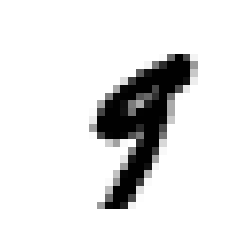

In [38]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

In [155]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### 이진 분류기 평가지표

In [156]:
# 숫자 5인지 아닌지 분류
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [158]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

c:\users\affinity\.conda\envs\ds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


array([False])

### Confusion Matrix
- 출처 : http://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png
- sklearn에서 제공하는 confusion matrix는 Actual과 Predict의 Positive와 Negative 위치가 반대임
- 즉, 아래 그림에서 보이는 것을 대각선으로 봐야함
    - 예를 들어 (0, 0)에 현재는 True Positive가 들어있으나 sklearn에서 (0, 0)으로 접근하면 True Negative를 얻음
    - 그림에서는 (1, 0)에 False Positive라 되어있지만 sklearn에서는 False Negative를 반환함
- 출처 : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
- Thus in binary classification, the count of true negatives is $C_{0, 0}$, false negatives is $C_{1, 0}$, true positives is $C_{0, 1}$ and false positives is $C_{1, 1}$.

![title](http://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png)

In [143]:
from sklearn.metrics import confusion_matrix

y_true = y_test_5.copy()
y_pred = sgd_clf.predict(X_test)
conf = confusion_matrix(y_true, y_pred)
print(conf)
print('\n(0, 0) == True Negative')
print('(1, 0) == False Negative')
print('(0, 1) == False Positive')
print('(1, 1) == True Positive')

[[8139  969]
 [  59  833]]

(0, 0) == True Negative
(1, 0) == False Negative
(0, 1) == False Positive
(1, 1) == True Positive


### Precision (정밀도)
- 모델이 True라고 분류한 것 중에서 실제로 True인 것의 비율
- Positive 정답률, PPV(Positive Predictive Value)
$$precision = {{TP}\over {TP + FP}}$$

In [144]:
from sklearn.metrics import precision_score

print('Precision = {:.4f}'.format(precision_score(y_true, y_pred)))
print('It is same to TP / (TP + FP) = {:.4f}'.format(conf[1, 1] / (conf[1, 1] + conf[0, 1])))

Precision = 0.4623
It is same to TP / (TP + FP) = 0.4623


### Recall (재현율)
- 실제 True인 것 중에서 모델이 True라고 예측할 것의 비율
- 통계학에서는 **sensitivity**로, 그리고 다른 분야에서는 **hit rate**라는 용어로도 사용
- precision은 _모델의 입장_에서, recall은 _실제 정답(data)_의 입장에서 바라봄
$$recall = {{TP}\over {TP + FN}}$$

In [188]:
from sklearn.metrics import recall_score

print('Recall = {:.4f}'.format(recall_score(y_true, y_pred)))
print('It is same to TP / (TP + FN) = {:.4f}'.format(conf[1, 1] / (conf[1, 1] + conf[1, 0])))

Recall = 0.9339
It is same to TP / (TP + FN) = 0.9339


### Precision-Recall Trade-off
- with Type 1, 2 error
$$(Type\,1\,error) = P(\,reject\,H_0\,|\,H_0\,is\,true\,)$$
$$(Type\,2\,error) = P(\,accept\,H_0\,|\,H_0\,is\,not\,true\,)$$
- 가설 검정 시에 어떤 상황에서 어떤 가설을 받아들일 지의 기준이 필요
- 그 기준에서 critical region을 잡게 된다.
    - _Type 1 error_는 $H_0$이 true일 때, _reject_ $H_0$일 확률을 의미
    - 즉, 미리 설정해둔 critical regino의 표본을 뽑을 확률
- 아래 그림에서 Any mean이 기준점이고 $H_0$ 관점에서 빨간색 영역이 기각역이라고 볼 수 있음
    - 이 기각역에 따라 _Type 2 error_도 정해짐
- Any mean을 좌유로 조절하게되면 _Type 1, 2 error_의 크기가 변함
- 하지만 둘다 커지거나 둘다 작아지는 경우가 없는 trade-off 관계
- Precision-Recall Trade off
    - Precision과 Recall은 TP를 분자로써 같이함
    - 분모에는 TP에 _Type 1, 2 error_에 해당하는 FN, FP를 더하여 계산
    - 이때, FN, FP는 각각 _Type 1, 2 error_에 있음
    - 이에 따라 Precision과 Recall 또한 Trade off 관계를 가짐

- 출처 : https://www.abtasty.com/blog/type-1-and-type-2-errors/
<img src="https://dp8v87cz8a7qa.cloudfront.net/45396/5bd20d03240611540492547.png" width="400" height="300">

In [162]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

c:\users\affinity\.conda\envs\ds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
c:\users\affinity\.conda\envs\ds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
c:\users\affinity\.conda\envs\ds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have 

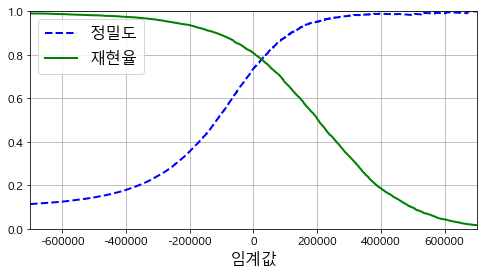

In [164]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율", linewidth=2)
    plt.xlabel("임계값", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.grid(True)
plt.show()

## 왜 문제가 생길까?

### Accuracy
- 정확도는 가장 직관적으로 모델의 성능을 나타낼 수 있는 평가지표
- 하지만 domain의 bias를 고려해야 함
- true, false의 ratio가 크게 다를 경우, 더 많은 label 쪽으로 예측하려는 경향이 나타남
$$Accuracy = {{TP + TN} \over {TP + FN + FP + TN}}$$

In [189]:
from sklearn.metrics import accuracy_score

print('Accuracy = {:.4f}'.format(accuracy_score(y_true, y_pred)))
print('It is same to (TP + TN) / (TP + FN + FP + TN) = {:.4f}'.format(
        (conf[1, 1] + conf[0, 0]) / (conf[1, 1] + conf[1, 0] + conf[0, 1] + conf[0, 0]))
     )

Accuracy = 0.8972
It is same to (TP + TN) / (TP + FN + FP + TN) = 0.8972


### F1 score
- precision과 recall의 조화평균
- F1 score는 데이터 label이 불균형 구조일 때 모델의 성능을 정확하게 평가할 수 있음
- 왜 산술평균이 아닌 조화평균을 사용할까? > Trade off 관계라서 산술평균은 의미 x
$$F1-score\,=\,2\,\times\,{1\over{{1\over Precision}+{1\over Recall}}}=2\,\times\,{{Precision\,\times\,Recall}\over{Precision\,+\,Recall}}$$

In [190]:
from sklearn.metrics import f1_score

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print('Precision = {:.4f}'.format(f1_score(y_true, y_pred)))
print('It is same to 2 * precision * recall / (precision + recall) = {:.4f}'.format(
       2 * precision * recall / (precision + recall)
     ))

Precision = 0.6184
It is same to 2 * precision * recall / (precision + recall) = 0.6184


### ROC & AUC
- ROC curve
    - **R**eceiver **O**perating **C**haracteristic Curve
    - False positive rate(1-specificity)를 x축으로, true positive rate(recall)을 y축으로 하여 둘 간의 관계를 표현한 그래프
- AUC
    - ROC curve의 밑부분 면적(**A**rea **U**nder the roc **C**urve; AUC)이 넓을수록 모형 성능이 높아짐
    - Thumb rule
        - Poor model (.5 ~ .7)
        - Fair model (.7 ~ .8)
        - Good model (.8 ~ .9)
        - Excellent model (..9 ~ 1.0)
- 주로 binary classification에 많이 사용
- 클래스별 분포가 다를 때, Accuracy의 단점을 보완
- 클래스별 분포가 겹치는 부분(Error 증가)이 많을 수록 직선에 가까워짐

### ROC 수식
- 기본적으로 ROC Curve는 Recall(행방향 : 실제값에 대해서 예측값이 어느정도로)에 대한 얘기
    - y축 : TPR(True Positive Rate, **Recall** , **sensitivity**)
    - x축 : 1 - TNR(True Negative Rate, **specificity**)
- Recall이 높다는 것은 실제 Positive 분포(TP)에 예측 Positive가 전부 들어오도록 하는 행위
- FN이 줄어들면서 TP는 증가
- 즉, TPR 증가

In [118]:
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot(np.linspace(0, 1, 5), np.linspace(0, 1, 5), color='darkblue', ls='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()

In [102]:
data_X, class_label = make_classification(n_samples=1000, n_classes=2,
                                          weights=[1, 1], random_state=1)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(data_X, class_label,
                                                    test_size=.3, random_state=1)

In [104]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [106]:
probs = model.predict_proba(X_test)
probs = probs[:, 1]
probs

array([0. , 0.8, 0. , 0.2, 1. , 0.8, 0.6, 1. , 0.8, 0.2, 1. , 0.8, 0. ,
       0.4, 1. , 0.2, 0.4, 0. , 1. , 0. , 0. , 0.4, 0.8, 0.6, 0.6, 0.8,
       0. , 0.4, 0.6, 0.6, 0.2, 0.2, 0.6, 0.8, 0.4, 0. , 0.2, 0.4, 1. ,
       0.2, 0. , 0.8, 0. , 0.8, 0.8, 0. , 1. , 0.8, 0.4, 0. , 0. , 0.6,
       0. , 0. , 0. , 0. , 0.6, 1. , 0.4, 0. , 1. , 0.4, 0.6, 0. , 0.6,
       0.4, 0. , 0.6, 0.8, 0.6, 1. , 0. , 0.4, 0. , 0.2, 1. , 0. , 0.8,
       0.8, 0.6, 0. , 0. , 0.6, 0.8, 0.6, 0.8, 0. , 0. , 0.2, 0.8, 0.2,
       0.4, 0.6, 0. , 0.8, 0.4, 0.8, 0.6, 0. , 0. , 1. , 0. , 1. , 0. ,
       0. , 1. , 0.6, 1. , 0.4, 0.6, 1. , 0. , 1. , 0.6, 0.8, 0.6, 0.8,
       0. , 0.6, 0. , 0. , 0.2, 0.2, 1. , 0.8, 0.4, 0.6, 1. , 0.8, 1. ,
       0.8, 0. , 0.8, 0.6, 0.6, 0.4, 0. , 0.8, 1. , 0.8, 0.8, 0.4, 0. ,
       0.2, 0.8, 0. , 0.8, 0.2, 0.2, 0.8, 0. , 0.4, 1. , 0.6, 0.4, 0. ,
       0.6, 0.8, 0. , 0.2, 0.8, 0.8, 0. , 0.6, 0.6, 0. , 0.8, 0. , 0.6,
       0.2, 0.8, 1. , 0. , 0. , 0.4, 0.8, 0.6, 0.8, 0.8, 0.8, 0.

In [107]:
roc = roc_curve(y_test, probs)
print('ROC: {}'.format(roc))
auc = roc_auc_score(y_test, probs)
print('AUC: {:.2f}'.format(auc))

ROC: (array([0.        , 0.01408451, 0.0915493 , 0.18309859, 0.33098592,
       0.5       , 1.        ]), array([0.        , 0.2721519 , 0.65189873, 0.89873418, 0.98101266,
       0.99367089, 1.        ]), array([2. , 1. , 0.8, 0.6, 0.4, 0.2, 0. ]))
AUC: 0.91


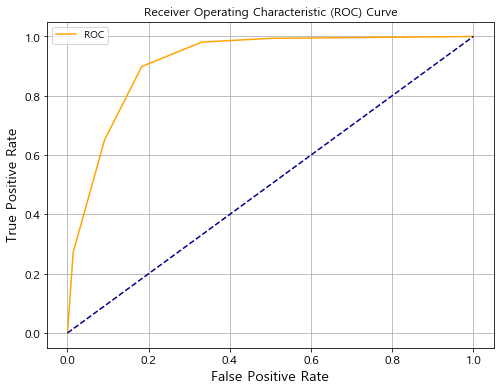

In [134]:
plt.figure(figsize=(8,6))
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
plt.grid(True)
plt.show()

### The holdout method

### K-fold cross-validation

In [166]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
iris = load_iris()
knn = KNeighborsClassifier()
scores = cross_val_score(knn, iris.data, iris.target, cv=5)
print('교차 검증 점수 :', scores)

교차 검증 점수 : [0.96666667 1.         0.93333333 0.96666667 1.        ]


In [169]:
from sklearn.model_selection import cross_validate

res = cross_validate(knn, iris.data, iris.target, cv=5,
                    return_train_score=True)
display(res)

{'fit_time': array([0.00049639, 0.00049591, 0.00050807, 0.00053167, 0.00049496]),
 'score_time': array([0.00198555, 0.00098062, 0.00095463, 0.00095606, 0.00102353]),
 'test_score': array([0.96666667, 1.        , 0.93333333, 0.96666667, 1.        ]),
 'train_score': array([0.96666667, 0.96666667, 0.975     , 0.975     , 0.96666667])}

In [170]:
print('Iris 레이블 :\n', iris.target)

Iris 레이블 :
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


### LOOCV (Leave-one-out cross-validation)

In [173]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(knn, iris.data, iris.target, cv=loo)
print('교차 검증 분할 횟수 :', len(scores))
print('평균 정확도 : {:.2f}'.format(scores.mean()))

교차 검증 분할 횟수 : 150
평균 정확도 : 0.97


### Shuffle-split cross-validation (임의 분할 교차 검증)

In [177]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(knn, iris.data, iris.target, cv=shuffle_split)
scores = ['{:.3f}'.format(score) for score in scores]
print('교차 검증 점수 :\n', scores)

교차 검증 점수 :
 ['0.947', '0.987', '0.973', '0.947', '0.973', '0.947', '0.987', '0.960', '0.960', '0.960']


### 반복 교차 검증

In [183]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

rskfold = RepeatedStratifiedKFold(random_state=42)
scores = cross_val_score(knn, iris.data, iris.target, cv=rskfold)
scores_str = ['{:.3f}'.format(score) for score in scores]
print('교차 검증 점수:\n', scores_str)
print('교차 검증 평균 점수: {:.3f}'.format(scores.mean()))

교차 검증 점수:
 ['0.967', '0.967', '0.967', '0.933', '1.000', '0.933', '1.000', '0.967', '0.967', '0.933', '0.967', '0.967', '1.000', '0.967', '0.933', '1.000', '0.967', '0.967', '0.867', '0.967', '0.967', '0.967', '0.967', '1.000', '0.967', '1.000', '0.933', '0.967', '0.967', '0.967', '0.933', '0.967', '1.000', '1.000', '0.967', '0.900', '0.967', '0.967', '1.000', '1.000', '0.967', '0.967', '1.000', '0.933', '0.933', '0.967', '0.967', '0.933', '1.000', '0.967']
교차 검증 평균 점수: 0.965


## 4-3 Grid Search

In [184]:
# 간단한 그리드 서치 구현
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print('훈련 세트의 크기: {}, 테스트 세트의 크기: {}'.format(
    X_train.shape[0], X_test.shape[0]))
best_score = 0
for gamma in [.001, .01, .1, 1, 10, 100]:
    for C in [.001, .01, .1, 1, 10, 100]:
        # 매개변수의 각 조합에 대해 SVC를 훈련시킵니다.
        svc = SVC(gamma=gamma, C=C)
        svc.fit(X_train, y_train)
        # 테스트 세트로 SVC를 평가합니다.
        score = svc.score(X_test, y_test)
        # 점수가 더 높으면 매개변수와 함께 기록합니다.
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma':gamma}
            
print('최고 점수 : {:.2f}'.format(best_score))
print('최적 매개변수 :', best_parameters)

훈련 세트의 크기: 112, 테스트 세트의 크기: 38
최고 점수 : 0.97
최적 매개변수 : {'C': 100, 'gamma': 0.001}


In [187]:
# 데이터를 훈련+검증 세트 그리고 테스트 세트로 분할
X_train_val, X_test, y_train_val, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
# 훈련=검증 세트를 훈련 세트와 검증 세트로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_val, y_train_val, random_state=1)
print('훈련 세트의 크기 : {}, 검증 세트의 크기 : {} 테스트 세트의 크기 : {}'.format(
        X_train.shape[0], X_valid.shape[0], X_test.shape[0]))
best_score = 0
for gamma in [.001, .01, .1, 1, 10, 100]:
    for C in [.001, .01, .1, 1, 10, 100]:
        # 매개변수의 각 조합에 대해 SVC를 훈련시킵니다.
        svc = SVC(gamma=gamma, C=C)
        svc.fit(X_train, y_train)
        # 테스트 세트로 SVC를 평가합니다.
        score = svc.score(X_valid, y_valid)
        # 점수가 더 높으면 매개변수와 함께 기록합니다.
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma':gamma}
# 훈련 세트와 검증 세트를 합쳐 모델을 다시 만든 후
# 테스트 세트를 사용해 평가합니다.
svc = SVC(**best_parameters)
svc.fit(X_train_val, y_train_val)
test_score = svc.score(X_test, y_test)
print('검증 세트에서 최고 점수 : {:.2f}'.format(best_score))
print('최적 매개변수 :', best_parameters)
print('최적 매개변수에서 테스트 세트 점수 : {:.2f}'.format(test_score))

훈련 세트의 크기 : 84, 검증 세트의 크기 : 28 테스트 세트의 크기 : 38
검증 세트에서 최고 점수 : 0.96
최적 매개변수 : {'C': 10, 'gamma': 0.001}
최적 매개변수에서 테스트 세트 점수 : 0.92


## 4-4 탐색적 자료 분석 (Exploratory Data Analysis; EDA)
- Kaggle, titanic dataset

출처 : https://3months.tistory.com/325

In [193]:
!kaggle competitions download -c titanic


  0%|          | 0.00/59.8k [00:00<?, ?B/s]
100%|##########| 59.8k/59.8k [00:00<00:00, 546kB/s]

  0%|          | 0.00/28.0k [00:00<?, ?B/s]
100%|##########| 28.0k/28.0k [00:00<00:00, 838kB/s]

  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 275kB/s]


In [196]:
train = pd.read_csv('./titanic/train.csv')
test = pd.read_csv('./titanic/test.csv')
submission = pd.read_csv('./titanic/gender_submission.csv')

In [197]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [198]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [199]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [200]:
train.info()

# Survived : 생존 여부 
# Pclass : 등급

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [203]:
train['Survived'] = train['Survived'].astype(object)
train['Pclass'] = train['Pclass'].astype(object)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null object
Pclass         891 non-null object
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(3), object(7)
memory usage: 83.6+ KB


In [206]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [208]:
train.isnull().sum() / len(train)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

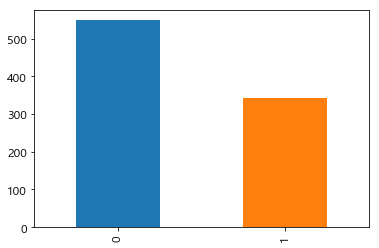

In [209]:
# 종속변수 분포 확인
# 교차검증 및 test를 어떻게 해야할지 감을 잡는 과정
train['Survived'].value_counts().plot(kind='bar')
plt.show()

In [213]:
cat_feature = [col  for col in train.columns 
               if (train[col].dtype == 'object') & (col != 'Survived')]
cat_feature

['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

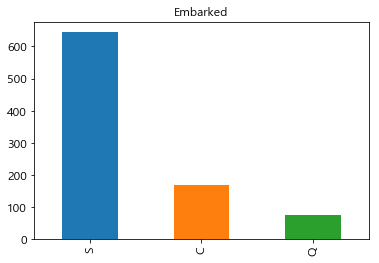

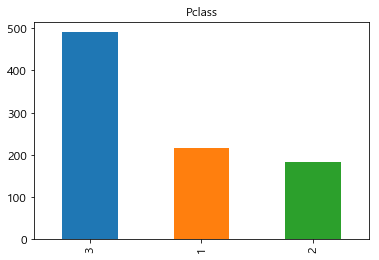

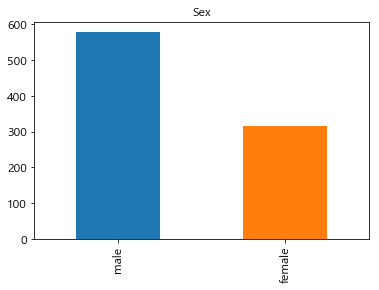

In [218]:
for col in ['Embarked', 'Pclass', 'Sex']:
    train[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()

In [1]:
sex_df = train.groupby(['Sex', 'Survived'])['Survived'].count().unstack('Survived')
sex_df.plot(kind='bar', figsize=(10, 10))
plt.show()

NameError: name 'train' is not defined

In [232]:
numeric_col = [col for col in train.columns 
     if (train[col].dtype != object)&(col != 'PassengerId')]
numeric_col = sorted(numeric_col)
numeric_col

['Age', 'Fare', 'Parch', 'SibSp']

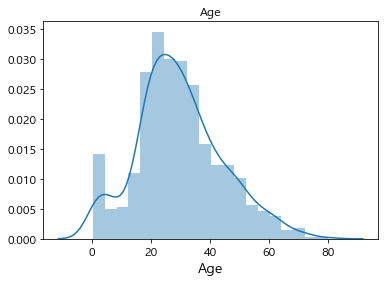

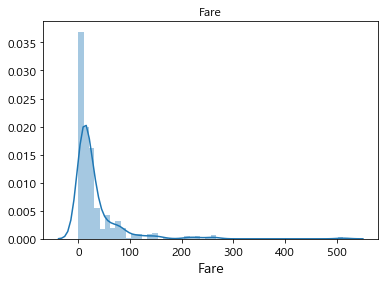

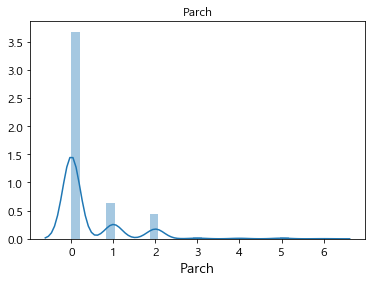

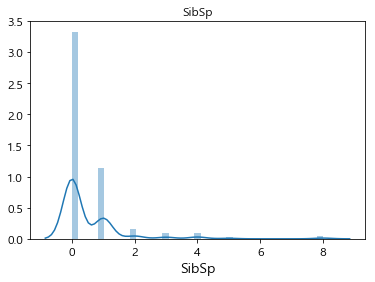

In [233]:
for col in numeric_col:
    sns.distplot(train.loc[train[col].notnull(), col])
    plt.title(col)
    plt.show()

In [265]:
train['Age'] = train.groupby(['Pclass', 'Sex', 'Parch']).transform(lambda x : x.fillna(x.mean()))['Age'].astype(int)

In [267]:
train.Age.isnull().sum()

0

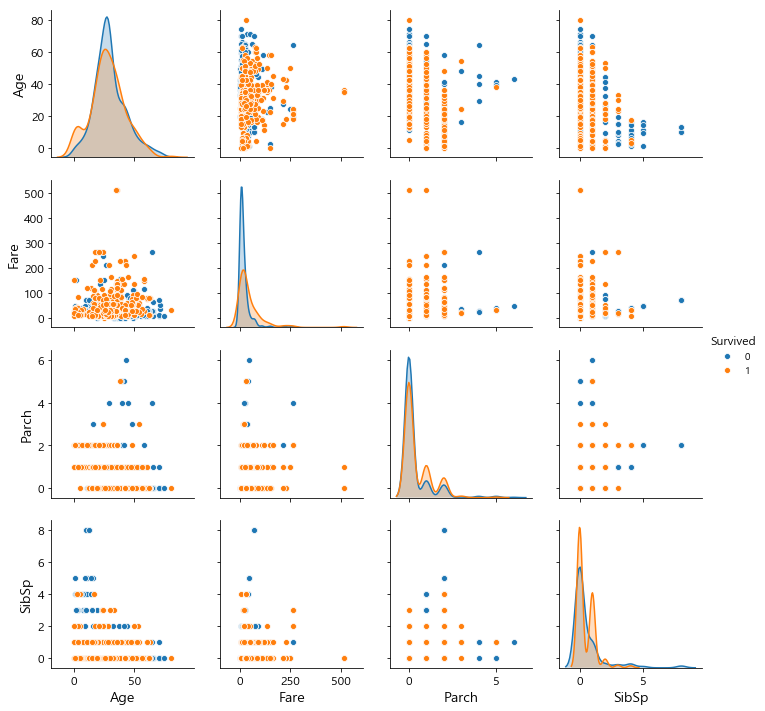

In [268]:
sns.pairplot(train[numeric_col + ['Survived']], hue='Survived', 
             x_vars=numeric_col, y_vars=numeric_col)
plt.show()

### EDA - Safe Driver

In [269]:
!kaggle competitions download -c porto-seguro-safe-driver-prediction


  0%|          | 0.00/508k [00:00<?, ?B/s]
100%|##########| 508k/508k [00:00<00:00, 1.06MB/s]

  0%|          | 0.00/16.2M [00:00<?, ?B/s]
  6%|6         | 1.00M/16.2M [00:00<00:10, 1.49MB/s]
 12%|#2        | 2.00M/16.2M [00:01<00:10, 1.47MB/s]
 18%|#8        | 3.00M/16.2M [00:02<00:09, 1.42MB/s]
 25%|##4       | 4.00M/16.2M [00:03<00:09, 1.36MB/s]
 31%|###       | 5.00M/16.2M [00:03<00:08, 1.46MB/s]
 37%|###6      | 6.00M/16.2M [00:04<00:07, 1.48MB/s]
 43%|####3     | 7.00M/16.2M [00:05<00:06, 1.41MB/s]
 49%|####9     | 8.00M/16.2M [00:05<00:06, 1.42MB/s]
 55%|#####5    | 9.00M/16.2M [00:06<00:05, 1.40MB/s]
 62%|######1   | 10.0M/16.2M [00:07<00:04, 1.38MB/s]
 68%|######7   | 11.0M/16.2M [00:08<00:03, 1.47MB/s]
 74%|#######3  | 12.0M/16.2M [00:08<00:02, 1.52MB/s]
 80%|########  | 13.0M/16.2M [00:09<00:02, 1.58MB/s]
 86%|########6 | 14.0M/16.2M [00:10<00:01, 1.42MB/s]
 92%|#########2| 15.0M/16.2M [00:11<00:00, 1.39MB/s]
 99%|#########8| 16.0M/16.2M [00:11<00:00, 1.49MB/s]
100%|#######

In [3]:
train = pd.read_csv('./safe driver/train.csv', na_values=['-1', '-1.0'])
test = pd.read_csv('./safe driver/test.csv', na_values=['-1', '-1.0'])
submission = pd.read_csv('./safe driver/sample_submission.csv')

In [4]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [5]:
test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1.0,8,1.0,0.0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2.0,5,1.0,0.0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1.0,3,0.0,0.0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0
3,3,0,1.0,6,0.0,0.0,1,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,4,5,1.0,7,0.0,0.0,0,0,0,1,...,4,0,0,4,0,1,1,0,0,1


In [6]:
submission.head()

,id,target
0,0,0.0364
1,1,0.0364
2,2,0.0364
3,3,0.0364
4,4,0.0364


In [7]:
print(train.shape, test.shape)

(595212, 59) (892816, 58)


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     594996 non-null float64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595129 non-null float64
ps_ind_05_cat     589403 non-null float64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64

In [9]:
train.isnull().sum()

id                     0
target                 0
ps_ind_01              0
ps_ind_02_cat        216
ps_ind_03              0
ps_ind_04_cat         83
ps_ind_05_cat       5809
ps_ind_06_bin          0
ps_ind_07_bin          0
ps_ind_08_bin          0
ps_ind_09_bin          0
ps_ind_10_bin          0
ps_ind_11_bin          0
ps_ind_12_bin          0
ps_ind_13_bin          0
ps_ind_14              0
ps_ind_15              0
ps_ind_16_bin          0
ps_ind_17_bin          0
ps_ind_18_bin          0
ps_reg_01              0
ps_reg_02              0
ps_reg_03         107772
ps_car_01_cat        107
ps_car_02_cat          5
ps_car_03_cat     411231
ps_car_04_cat          0
ps_car_05_cat     266551
ps_car_06_cat          0
ps_car_07_cat      11489
ps_car_08_cat          0
ps_car_09_cat        569
ps_car_10_cat          0
ps_car_11_cat          0
ps_car_11              5
ps_car_12              1
ps_car_13              0
ps_car_14          42620
ps_car_15              0
ps_calc_01             0


In [10]:
train.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,594996.000000,595212.000000,595129.000000,589403.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.359799,4.423318,0.416992,0.419038,0.393742,0.257033,0.163921,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.663193,2.699902,0.493062,1.350023,0.488579,0.436998,0.370205,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
test.isnull().sum()

id                     0
ps_ind_01              0
ps_ind_02_cat        307
ps_ind_03              0
ps_ind_04_cat        145
ps_ind_05_cat       8710
ps_ind_06_bin          0
ps_ind_07_bin          0
ps_ind_08_bin          0
ps_ind_09_bin          0
ps_ind_10_bin          0
ps_ind_11_bin          0
ps_ind_12_bin          0
ps_ind_13_bin          0
ps_ind_14              0
ps_ind_15              0
ps_ind_16_bin          0
ps_ind_17_bin          0
ps_ind_18_bin          0
ps_reg_01              0
ps_reg_02              0
ps_reg_03         161684
ps_car_01_cat        160
ps_car_02_cat          5
ps_car_03_cat     616911
ps_car_04_cat          0
ps_car_05_cat     400359
ps_car_06_cat          0
ps_car_07_cat      17331
ps_car_08_cat          0
ps_car_09_cat        877
ps_car_10_cat          0
ps_car_11_cat          0
ps_car_11              1
ps_car_12              0
ps_car_13              0
ps_car_14          63805
ps_car_15              0
ps_calc_01             0
ps_calc_02             0


In [12]:
train.target.unique()

array([0, 1], dtype=int64)

In [13]:
train['target'].value_counts() / len(train)

0    0.963552
1    0.036448
Name: target, dtype: float64

In [14]:
test['target'] = np.nan
df = pd.concat([train, test], axis=0)

In [15]:
def count_plot(col, data, hue=None, figsize=(10, 5)):
    f, ax = plt.subplots(figsize=figsize)
    sns.countplot(x=col, hue=hue, data=data, alpha=.5)
    plt.show()

def dist_plot(col, data, figsize=(10, 5)):
    f, ax = plt.subplots(figsize=figsize)
    sns.distplot(data[col].dropna(), kde=False, bins=10)
    plt.show()
    
def bar_plot(col, data, figsize=(10, 5)):
    f, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=col, y='target', data=data)
    plt.show()

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     594996 non-null float64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595129 non-null float64
ps_ind_05_cat     589403 non-null float64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64

In [17]:
bin_col = [col for col in train.columns if col.find('bin') != -1]
cat_col = [col for col in train.columns if col.find('cat') != -1]
int_col = [col for col in train.columns if train[col].dtype == np.int64]
float_col = [col for col in train.columns if train[col].dtype == np.float64]

In [ ]:
for col in bin_col + cat_col + int_col:
    bar_plot(col, df)

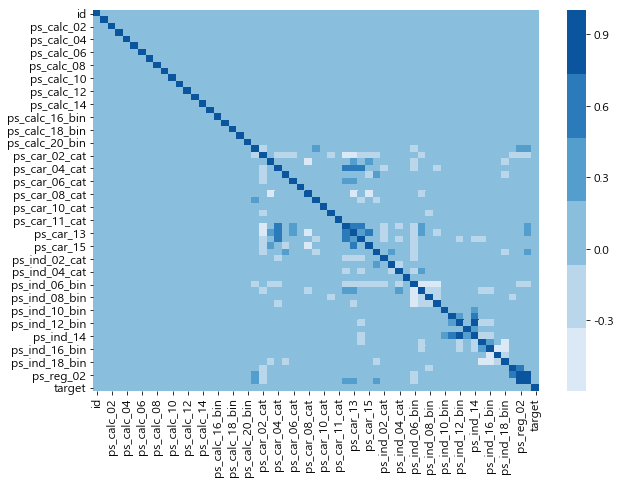

In [18]:
corr = df.corr()
cmap = sns.color_palette('Blues')
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr, cmap=cmap)

In [61]:
del_feat_autocorr = np.where((corr.replace({1:0}).abs() < .5).sum(axis=1))[0]
sub_corr = corr.iloc[del_feat_autocorr]
sub_corr = sub_corr[sub_corr.index]
sub_corr

,id,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,...,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,target
id,1.000000,0.000779,0.000212,-3.009710e-04,0.001556,-0.000681,-0.000181,0.000739,0.000516,1.072352e-03,...,-0.001265,-0.001280,-0.001434,-0.001463,0.001378,0.000790,-0.001076,-0.001053,-0.002048,-0.000188
ps_calc_01,0.000779,1.000000,-0.001436,2.035623e-04,0.000069,0.001015,0.000463,0.000791,0.000630,-1.509196e-04,...,0.000427,0.000423,-0.000007,-0.000333,0.001089,0.000158,-0.001181,0.000250,-0.000071,0.001782
ps_calc_02,0.000212,-0.001436,1.000000,1.049686e-03,-0.000374,-0.000890,0.001267,-0.000066,0.000348,-2.012914e-04,...,-0.000248,-0.000146,-0.000457,-0.000685,0.000771,-0.000031,0.001975,-0.000001,0.000241,0.001360
ps_calc_03,-0.000301,0.000204,0.001050,1.000000e+00,-0.001004,-0.000971,0.000443,0.000771,0.000106,-6.634653e-04,...,0.001349,-0.000164,-0.000159,0.000288,0.000639,-0.000796,-0.001962,-0.000211,0.001041,0.001907
ps_calc_04,0.001556,0.000069,-0.000374,-1.004015e-03,1.000000,0.000507,-0.000323,0.000696,-0.000555,2.318449e-04,...,0.000085,-0.000324,0.000224,-0.000458,0.001044,-0.001082,0.000192,0.000300,-0.000467,0.000033
ps_calc_05,-0.000681,0.001015,-0.000890,-9.710157e-04,0.000507,1.000000,-0.000588,-0.001230,-0.000403,2.952246e-04,...,-0.000827,0.000290,0.001286,-0.000051,-0.000462,-0.000957,-0.000431,-0.000415,-0.000567,0.000771
ps_calc_06,-0.000181,0.000463,0.001267,4.431070e-04,-0.000323,-0.000588,1.000000,-0.000352,0.001141,2.785765e-04,...,-0.001022,-0.000312,0.000213,-0.000002,0.000074,-0.000057,-0.000375,0.000466,-0.000351,0.000082
ps_calc_07,0.000739,0.000791,-0.000066,7.714227e-04,0.000696,-0.001230,-0.000352,1.000000,-0.002721,1.379888e-03,...,-0.000781,0.000318,0.000953,0.000815,-0.000667,-0.000783,0.000053,-0.000145,-0.000955,-0.000103
ps_calc_08,0.000516,0.000630,0.000348,1.064219e-04,-0.000555,-0.000403,0.001141,-0.002721,1.000000,-7.656836e-05,...,0.000640,0.002066,-0.000682,-0.001908,0.000886,0.000452,-0.001461,-0.000554,0.000564,-0.001006
ps_calc_09,0.001072,-0.000151,-0.000201,-6.634653e-04,0.000232,0.000295,0.000279,0.001380,-0.000077,1.000000e+00,...,-0.001691,0.000429,-0.001237,-0.002077,0.001915,0.000232,-0.000328,0.001094,0.001142,0.000719


In [62]:
features = np.abs(sub_corr.loc['target']).sort_values(ascending=False)[np.where(np.abs(sub_corr.loc['target']).sort_values(ascending=False) > .02)[0]].index
features

Index(['target', 'ps_car_13', 'ps_car_12', 'ps_ind_17_bin', 'ps_reg_02',
       'ps_ind_07_bin', 'ps_ind_06_bin', 'ps_reg_03', 'ps_car_04_cat',
       'ps_ind_05_cat', 'ps_car_02_cat', 'ps_ind_16_bin', 'ps_car_15',
       'ps_reg_01', 'ps_ind_15', 'ps_car_03_cat', 'ps_car_08_cat'],
      dtype='object')

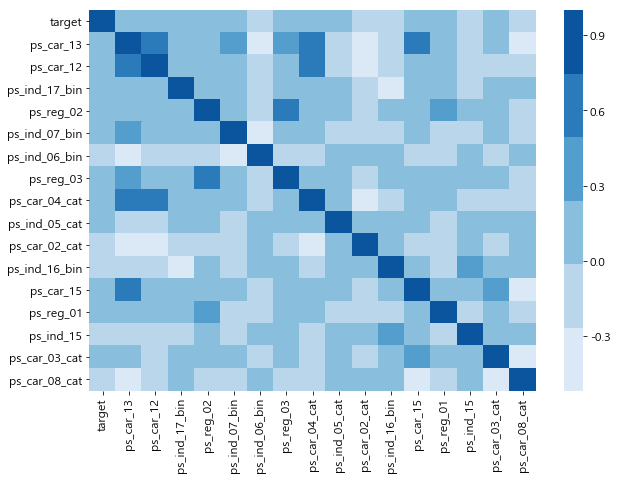

In [63]:
corr_sub = df[features].corr()
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr_sub, cmap=cmap)

In [ ]:
df['is_test'] = df['target'].isnull()
for col in bin_col + cat_col + int_col:
    bar_plot(col, df, 'is_test')